## Casos de Testes - Estimativa de coeficientes para regressão logística através de gradient descent e cross entropy

### Objetivo 
Com base no modelo apresentado em `gradient_descent.ipynb`, neste notebook iremos testar alguns casos, trocando valores das variáveis vitais para a estimativa, como a quantidade de **iterações** para se encontrar os coenficientes, o valor de **epsilon**, tal qual define as limitações, e o valor de **alpha** que define a suavidade da descida do gradiente.

#### Teorias utilizadas
- Gradiente
- Descida Gradiente 
- Cross Entropy

#### Dados Coletados


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

notas = pd.read_csv('https://raw.githubusercontent.com/celsocrivelaro/simple-datasets/main/notas-estudantes.csv')

### Funções montadas para o gradiente e para a estimativa

#### Função de estimado f(x) sigmóide
A função **sigmóide** é utilizada para tranformar um dado quatitativo em qualitativo. A través da função, podemos atribuir significados binários à resultante $y$ de nossas variaveis quantitativas $x$.

$$f(x) = \frac{1}{1+e^{ - a\cdot x_1 - b\cdot x_2 - c}}$$

ou 

$$f(x_1, x_2) = \frac{1}{1+e^{-(a_1 \cdot x_1 + a_2 \cdot x_2 + a_3)}}$$



#### Função de erro err(x) cross entropy
Seja $f(x^i_1, x^i_2) = F_i$ e $Y$ nossos dados coletados

$$ERR(Y_i, F_i) = \sum_{i=1}^{N} ( Y_i \cdot \ln{F_i} + (1-Y_i)\cdot(\ln{1 - F_i} ))$$

<br>

#### Derivadas da função de erro para o gradiente

z = f(x,y)

∂L/∂a = 1/N * X * (p(x,y) - z)

∂L/∂b = 1/N * Y * (p(x,y) - z)

∂L/∂c = 1/N * 1 * (p(x,y) - z)

In [3]:

def sigmoidal(a1, a2, a3, x1, x2): 
    e = np.exp(-a1*x1 -a2*x2 - a3, dtype=np.float128);
    return 1 / (1 + e);

def perda(y: np.array, p: np.array):
    N = len(y);
    values = -(y * np.log(p) + (1 - y) * np.log(1 - p)); 
    return np.sum(values)/N;

def gradiente(a1, a2, a3, x1, x2, y):
    N = len(y);
    grada1 = np.sum(x1 * (sigmoidal(a1, a2, a3, x1, x2) - y)) / N
    grada2 = np.sum(x2 * (sigmoidal(a1, a2, a3, x1, x2) - y)) / N
    grada3 = np.sum(sigmoidal(a1, a2, a3, x1, x2) - y)/N
    return grada1, grada2, grada3;



#### Classificador

O Classificador armazena informações como erros, os trajetos dos coeficientes e é delimitado pelo **alpha** e pelo **lim**, não quero falar muito sobre ele, mas a operação realizada no cálculo dos coeficientes é que para cada iteração:

Seja $A$ o conjunto dos coeficientes, para cara $a_i \in A$:

$$a_i \leftarrow a_i - \alpha \cdot \frac{\partial ERR}{\partial a_i}$$

ou

$$A \leftarrow A - \alpha \nabla ERR$$

In [4]:
def classificador(y, x1, x2, a1 = 0.01, a2 = 0.01, a3 = 3, iters = 10000, alpha = 1e-6, lim = 1e-6):
    N = len(y);
    cnt = 0;
    err_atual = 0;
    err_anter = float('inf');
    erros = []
    a1_list = []
    a2_list = []
    for i in range(1,iters):
        estimados = sigmoidal(a1, a2, a3, x1, x2);
        err_atual = perda(y, estimados); 
        erros.append(err_atual);
        a1_list.append(a1);
        a2_list.append(a2);
        
        cnt+= 1;
        if (abs(err_atual - err_anter) <= lim): 
            print("Coeficientes encontrados {} iterações".format(cnt));
            print(" a1 = {} a2 = {} a3 = {}".format(a1, a2, a3));
            return a1, a2, a3, np.array(erros, dtype=np.float64), cnt, np.array(a1_list,dtype=np.float64), np.array(a2_list,dtype=np.float64);
        
        #recálculo
        err_anter = err_atual;
        grad1, grad2, grad3 = gradiente(a1, a2, a3, x1, x2, y);       
        a1 -= alpha * grad1;
        a2 -= alpha * grad2;
        a3 -= alpha * grad3;

    print("Coeficientes não encontrados");
    print(" a1 = {}  a2 = {} a3 = {}".format(a1, a2, a3));
    return a1, a2, a3, np.array(erros, dtype=np.float64), cnt, np.array(a1_list,dtype=np.float64), np.array(a2_list,dtype=np.float64);


### Plotagem dos dados

In [5]:
#para qualquer sigmoide menor que 0.7, o aluno é aprovado, para qualquer maior, o aluno é reprovado
# ALGORITMO ELABORADO PARA SOLUÇÃO DESSE VALOR (0.7)
"""
    Seja R os resultados, e E os estimados, podemos definir um valor I para dividir os resultados e classificarmos eles (que é o 0.7).

    Definimos um intervalo entre os valores E para cada R, ou seja, definimos (E,R=1) e (E, R=2) para dividirmos o conjunto E em dois, E1 e E0 (aprovado e reprovado). 
    
    Podemos então pegar a intersecção desse conjunto (neste caso entre 0.68 e 0.76), e então tiramos a média de todos os valores neste conjunto, ou seja, todos os valores cujo estimados estão entre, neste caso, 0.68 e 0.76. Este valor possivelmente é o nosso I.

    E aplitude do erro (lim = 1e-6)
"""
#resultado_estimado = np.where(sigmoids < 0.73, 1, 0);

def plotData(data, label_x, label_y, label_pos, label_neg, axes=None):
    neg = (notas['resultado'] == 0)
    pos = (notas['resultado'] == 1)
    
    if axes == None:
        axes = plt.gca()
    axes.scatter(data[pos][["nota_1"]], data[pos][["nota_2"]], marker='+', c='k', s=60, linewidth=2, label=label_pos)
    axes.scatter(data[neg][["nota_1"]], data[neg][["nota_2"]], c='y', s=60, label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon= True, fancybox = True);

def plotDataEstimada(data, label_x, label_y, label_pos, label_neg, axes=None):
    neg = (resultado_estimado == 0)
    pos = (resultado_estimado == 1)
    
    if axes == None:
        axes = plt.gca()
    axes.scatter(data[pos][["nota_1"]], data[pos][["nota_2"]], marker='+', c='r', s=10, linewidth=2, label=label_pos)
    axes.scatter(data[neg][["nota_1"]], data[neg][["nota_2"]], marker='x', c='g', s=10, label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon= True, fancybox = True);

-> Testando 10000 iterações e alpha:0.01


/home/farinap/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Coeficientes não encontrados
 a1 = 0.3886475765097407  a2 = -0.07864932675687483 a3 = -4.685791963026351
-> Testando 1000 iterações e alpha:0.01
Coeficientes não encontrados
 a1 = 0.3351439409687253  a2 = -0.13353454074451054 a3 = 2.230747813119899
-> Testando 10000 iterações e alpha:0.001
Coeficientes não encontrados
 a1 = -0.00387299025850664  a2 = -0.015659584825627067 a3 = 2.0945564675093067
-> Testando 1000 iterações e alpha:0.001
Coeficientes não encontrados
 a1 = -0.0093062770759494  a2 = -0.02180348987150973 a3 = 2.9062084517724447
-> Testando 10000 iterações e alpha:0.0001
Coeficientes encontrados 393 iterações
 a1 = -0.010229818579982512 a2 = -0.02216183305473556 a3 = 2.9959453941535585
-> Testando 1000 iterações e alpha:0.0001
Coeficientes encontrados 393 iterações
 a1 = -0.010229818579982512 a2 = -0.02216183305473556 a3 = 2.9959453941535585
-> Testando 10000 iterações e alpha:1e-05
Coeficientes encontrados 1043 iterações
 a1 = -0.012782169184402739 a2 = -0.01970052691644944

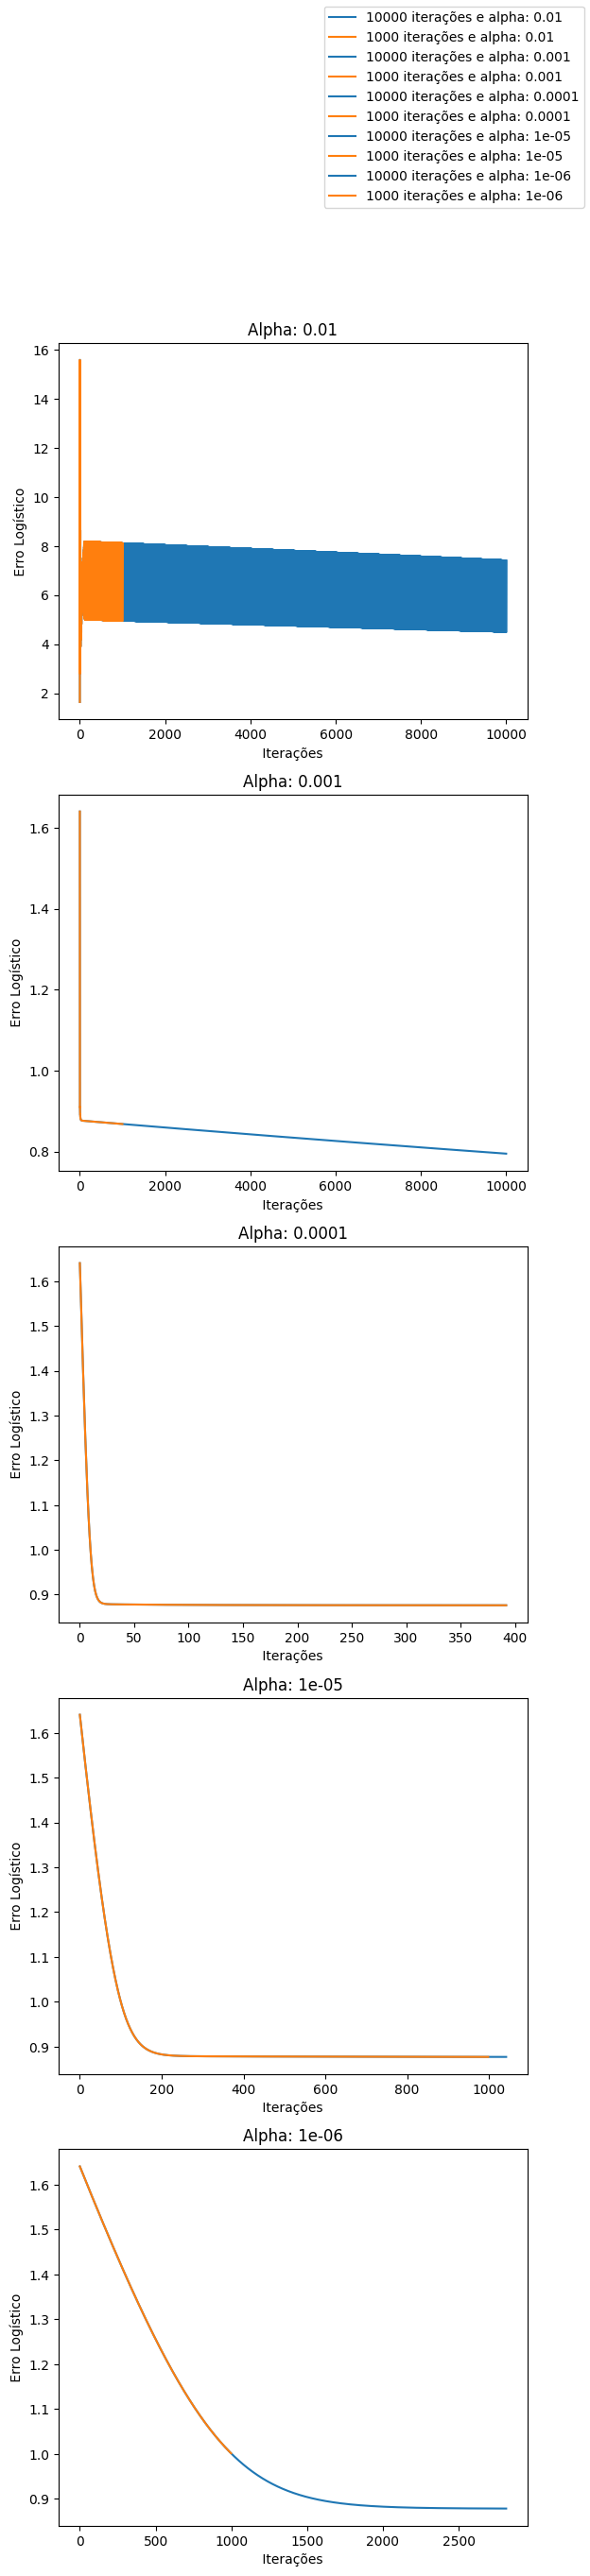

In [6]:
iteracoes = [10000,1000]
alpha = [0.01,0.001,0.0001,0.00001,1e-6]
fig, graph = plt.subplots(len(alpha));
gidx = 0
for i in alpha:
    for j in iteracoes:
        x1 = notas.nota_1;
        x2 = notas.nota_2;
        y = notas.resultado;

        print("-> Testando "+str(j)+" iterações e alpha:"+str(i))
        a, b, c, erros, cnt, a1_list, a2_list = classificador(y, x1, x2,alpha=i,iters=j);
        index = np.arange(cnt);
        graph[gidx].plot(index, erros, label=str(j)+" iterações e alpha: "+str(i));
        graph[gidx].set_xlabel(" Iterações ");
        graph[gidx].set_ylabel(" Erro Logístico ");
        graph[gidx].set_title("Alpha: "+str(i))
    gidx=gidx+1

#graph.set_xlim(0,10000)
#graph.set_ylim(0,5)
fig.legend()
fig.set_figheight(30)
fig.show();

Nesses casos, quando variamos o número de **iterações** ele acaba sendo sobreposto por sempre seguir a mesma curva no gráfico, passando pelos mesmos pontos, mas com um maior número de **iterações** temos mais precisão, tendo em vista que eventualmente o número pode ser atingido antes dos coeficientes apropriados serem encontrados.

Testando com 100000 iterações.
Coeficientes encontrados 2815 iterações
 a1 = -0.014693399987865027 a2 = -0.01721870367277665 a3 = 2.999366893317447
Testando com 50000 iterações.
Coeficientes encontrados 2815 iterações
 a1 = -0.014693399987865027 a2 = -0.01721870367277665 a3 = 2.999366893317447
Testando com 10000 iterações.
Coeficientes encontrados 2815 iterações
 a1 = -0.014693399987865027 a2 = -0.01721870367277665 a3 = 2.999366893317447
Testando com 1000 iterações.
Coeficientes não encontrados
 a1 = -0.007224904414947957  a2 = -0.008218949431231177 a3 = 2.9996542094361494


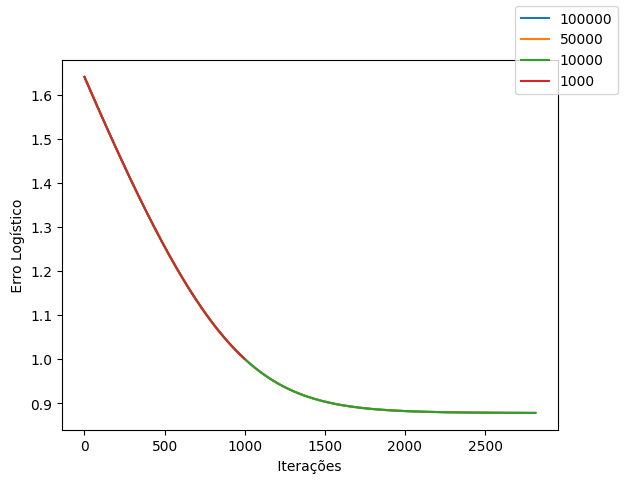

In [13]:
# Testando com diferentes N de iterações

fig, graph = plt.subplots();

iteracoes = [100000,50000,10000,1000]

for i in iteracoes:
    x1 = notas.nota_1;
    x2 = notas.nota_2;
    y = notas.resultado;
    print("Testando com "+str(i)+" iterações.")
    a, b, c, erros, cnt, a1_list, a2_list = classificador(y, x1, x2, iters=i);
    index = np.arange(cnt);
    graph.plot(index, erros, label=i);

graph.set_xlabel(" Iterações ");
graph.set_ylabel(" Erro Logístico ");


fig.legend()
fig.show();

Variando o limite *epsilon*, é possivel ver que, quando o limite é alto, ele é atingido com poucas iterações.

-> Testando com alpha de 0.01 e epsilon:0.001


/home/farinap/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Coeficientes não encontrados
 a1 = 0.3886475765097407  a2 = -0.07864932675687483 a3 = -4.685791963026351
-> Testando com alpha de 0.001 e epsilon:0.001
Coeficientes encontrados 4 iterações
 a1 = -0.010743786625009797 a2 = -0.01345224779479784 a3 = 2.999403706813006
-> Testando com alpha de 0.0001 e epsilon:0.001
Coeficientes encontrados 22 iterações
 a1 = -0.014318627206867317 a2 = -0.016285308928597437 a3 = 2.99944325176506
-> Testando com alpha de 1e-05 e epsilon:0.001
Coeficientes encontrados 148 iterações
 a1 = -0.01167975507057111 a2 = -0.013106250435108933 a3 = 2.9995438297714343
-> Testando com alpha de 1e-06 e epsilon:0.001
Coeficientes encontrados 2 iterações
 a1 = 0.009980029712653177 a2 = 0.009979007792254642 a3 = 2.9999996135917013
-> Testando com alpha de 0.01 e epsilon:1e-06
Coeficientes não encontrados
 a1 = 0.3886475765097407  a2 = -0.07864932675687483 a3 = -4.685791963026351
-> Testando com alpha de 0.001 e epsilon:1e-06
Coeficientes não encontrados
 a1 = -0.0038729902

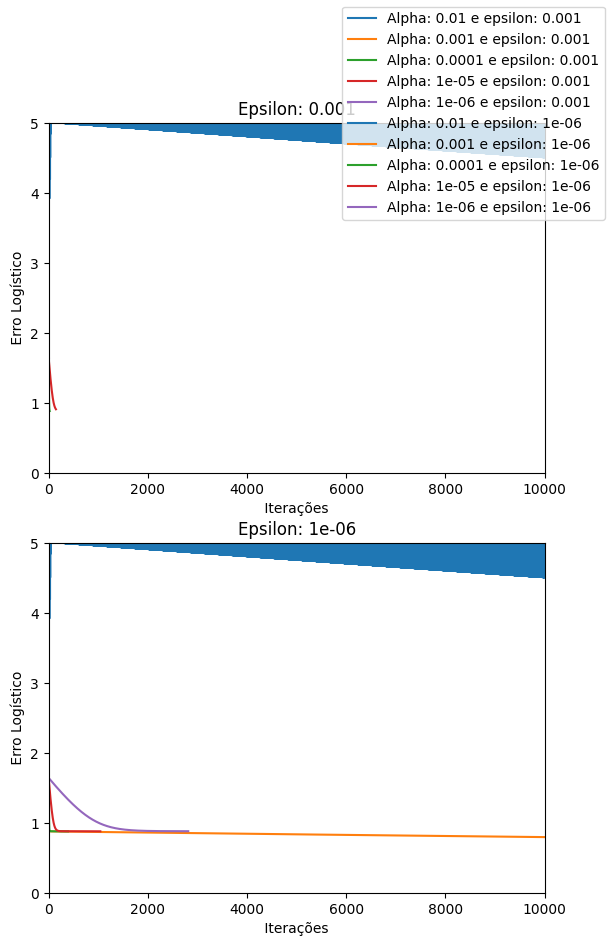

In [17]:
#iteracoes = [10000,1000]
alpha = [0.01,0.001,0.0001,0.00001,1e-6]
epsilon = [1e-3,1e-6]
fig, graph = plt.subplots(len(epsilon));
gidx = 0
for i in epsilon:
    for j in alpha:
        x1 = notas.nota_1;
        x2 = notas.nota_2;
        y = notas.resultado;

        print("-> Testando com alpha de "+str(j)+" e epsilon:"+str(i))
        a, b, c, erros, cnt, a1_list, a2_list = classificador(y, x1, x2,lim=i,alpha=j);
        index = np.arange(cnt);
        graph[gidx].plot(index, erros, label="Alpha: "+str(j)+" e epsilon: "+str(i));
        graph[gidx].set_xlabel(" Iterações ");
        graph[gidx].set_ylabel(" Erro Logístico ");
        graph[gidx].set_title("Epsilon: "+str(i))
    graph[gidx].set_xlim(0,10000)
    graph[gidx].set_ylim(0,5)
    gidx=gidx+1

fig.legend()
fig.set_figheight(10)
#graph.set_xlim(0,5000)
fig.show();